In [100]:
import numpy as np
import matplotlib.pyplot as plt
from distance import *
from scipy.spatial import  distance_matrix


In [101]:
import networkx as nx

def get_fv_dtm(X,m):
    # return barcode and persistence diagram
    dimension_max = 2
    p = 1
    st_DTM = DTMFiltration(X, m, p, dimension_max)
    fv = list()
    for x in st_DTM.get_filtration():
        fv.append(x)
    return fv

def draw_graph(data,dm,thres,value,qps):
    # Given threhlod \epsilond
    # raw sublevel set of filter function and corresponding skeleton
    eps = np.finfo(data.dtype).eps
    N = data.shape[0]
    dm[range(N),range(N)] = thres+1000  # set diag value
    r_idx,c_idx = np.where(dm<thres+eps)
    n = r_idx.shape[0]
    r_idx = np.reshape(r_idx,(n,1))
    c_idx = np.reshape(c_idx,(n,1))
    edgelist = np.concatenate((r_idx,c_idx),axis=1)
    G = nx.Graph()
    G.add_edges_from(edgelist)
    n_nodes = N
    pos = {i:  tuple(data[i,:]) for i in range(n_nodes)}
    # area where value of function< thres
    idx = np.where(value<thres)[0]
    value = value[idx]
    qps = qps[idx,:]
    n_qps = qps.shape[0]
    print('number of selected query points = ',n_qps)
    # plot 
    plt.figure()
    # plt.scatter(qps[:,0],qps[:,1],c='#90EE90',s=10)
    nx.draw(G, pos, node_size=0.5, width=0.1,nodelist=[i for i in range(n_nodes)] ,node_color='black')
    plt.axis('equal')


def draw_graph_dtm(X,fv,thres,value,qps):
    n_nodes = X.shape[0]
    edgelist = []
    for p,v in fv:
        if v<=thres:
            if len(p)==2:
                edgelist.append(p)
            elif len(p)==3:
                edgelist.append([p[0],p[1]])
                edgelist.append([p[0],p[2]])
                edgelist.append([p[2],p[1]])
    edgelist = np.array(edgelist)
    G = nx.Graph()
    G.add_edges_from(edgelist)
    pos = {i:  tuple(X[i,:]) for i in range(n_nodes)}
    # area where value of function < thres
    idx = np.where(value<thres)[0]
    value = value[idx]
    qps = qps[idx,:]
    n_qps = qps.shape[0]
    print('number of selected query points = ',n_qps)
    # plot
    # plt.scatter(qps[:,0],qps[:,1],c='#90EE90',s=10)
    nx.draw(G, pos, node_size=0.5, width=0.3,nodelist=[i for i in range(n_nodes)] ,node_color='black')
    plt.axis('equal')

In [102]:
def noisify (points, noise_level):
    return points + noise_level * np.random.normal(size=points.shape)

def make_perfect_eyegalss():
    a_ = np.pi/24
    num_1 = 100
    a_lst = np.linspace(a_,2*np.pi-a_,num=num_1)
    r = 2
    c1 = np.array([[r*np.cos(a),r*np.sin(a)] for a in a_lst])
    c1 = c1-np.array([[r+r*np.cos(np.pi/12),0]])

    c2 = np.copy(c1)
    c2[:,0] = -1*c2[:,0]

    num_2 = int(num_1*2*np.pi*r*(1-2*a_)/(2*np.pi*4))
    
    C = np.r_[c1,c2]
    line_base = np.linspace(-2,2,num=num_2)
    line_1 = np.array([[x,r*np.sin(a_)] for x in line_base])
    line_2 = np.array([[x,-1*r*np.sin(a_)] for x in line_base])
    X = np.concatenate([C,line_1,line_2],axis=0)
    Y = np.array([0]*num_1+[1]*num_1+[2]*num_2+[3]*num_2)
    idxs = get_mid_index(c1,c2,line_1,line_2)
    # Z = np.concatenate([A,B,C,D],axis=0)
    return X,Y,idxs

def make_3rings():
    X,_,_ = make_perfect_eyegalss()
    r = (2*2*np.pi*2*23/24+2*4)/(2*np.pi)
    number_ring = X.shape[0]
    a_lst = np.linspace(0,2*np.pi,num=number_ring)
    X_1 = np.array([[r*np.cos(a),r*np.sin(a)] for a in a_lst])
    X_2 = X_1 * 3

    X_1 = X_1-np.array([[0,4*r]])
    X_2 = X_2+np.array([[6*r,-2*r]])

    X = add_uni_noise(X,20)
    X_1 = add_uni_noise(X_1,20)
    X_2 = add_uni_noise(X_2,20)

    data = np.concatenate([X,X_1,X_2],axis=0)
    return data
    

def get_mid_index(c1,c2,line_1,line_2):
    idx_1 = int(c1.shape[0]/2)
    idx_2 = int(c2.shape[0]/2)+int(c1.shape[0])
    idx_3 = int(line_1.shape[0]/2)+int(c1.shape[0]+c2.shape[0])
    idx_4 = int(line_2.shape[0]/2)+int(c1.shape[0]+c2.shape[0]+line_1.shape[0])
    return [idx_1,idx_2,idx_3,idx_4]

def add_uni_noise(X,N):
    xy_min = [np.min(X[:,0]),np.min(X[:,1])]
    xy_max = [np.max(X[:,0]),np.max(X[:,1])]
    noise = np.random.uniform(low=xy_min, high=xy_max, size=(N,2))
    return np.r_[X,noise]

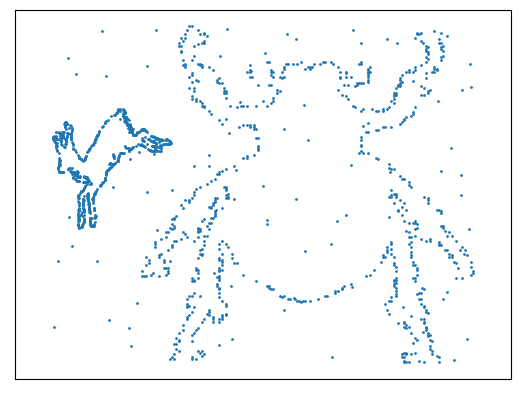

In [103]:
import scipy
X = scipy.io.loadmat('ds_db.mat')['data']
plt.scatter(X[:,0],X[:,1],s=1)
plt.axis('equal')
plt.xticks([]),plt.yticks([])
plt.show()

In [104]:
# Eyeglasses dataset
# X,Y,idxs= make_perfect_eyegalss()
# dm = distance_matrix(X,X)
# # plt.scatter(X[:,0],X[:,1],s=3,color='black')
# plt.scatter(X[:,0],X[:,1],s=3,c=Y)
# plt.scatter(X[idxs,0],X[idxs,1],s=30,color='red',marker='X')
# plt.axis('equal')

# eps = 0.2
# plt.text(X[idxs[0],0]+eps,X[idxs[0],1]+eps, '$A$', fontsize = 22)
# plt.text(X[idxs[1],0]-eps*4,X[idxs[1],1]-eps*4, '$B$', fontsize = 22)
# plt.text(X[idxs[2],0]+eps,X[idxs[2],1]+eps, '$C$', fontsize = 22)
# plt.text(X[idxs[3],0]-eps*4,X[idxs[3],1]-eps*4, '$D$', fontsize = 22)

# plt.xticks([]),plt.yticks([])
# plt.savefig('perfect_eyeglasses_with_label.png',dpi=600)


In [105]:
# Choose your filter 
choice_lst = ['rips','dtm','cknn','lambda']
choice_ = 'lambda'
assert choice_ in choice_lst,'wrong filter'

In [106]:
k = 10
p = 2
# dm_ori = distance_matrix(X,X) # Euclidean distance
# dm_ori = compute_Riemannian_distance(X,k) # Geodesic distance
dm_ori = deal_inf(compute_fermat_distance_D(X,p,k)) # Fermat distance


Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


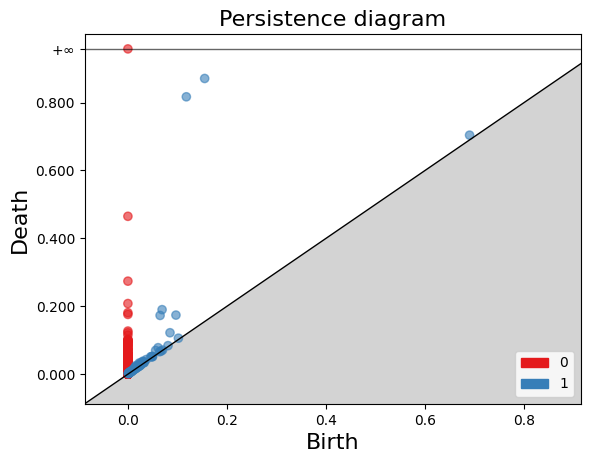

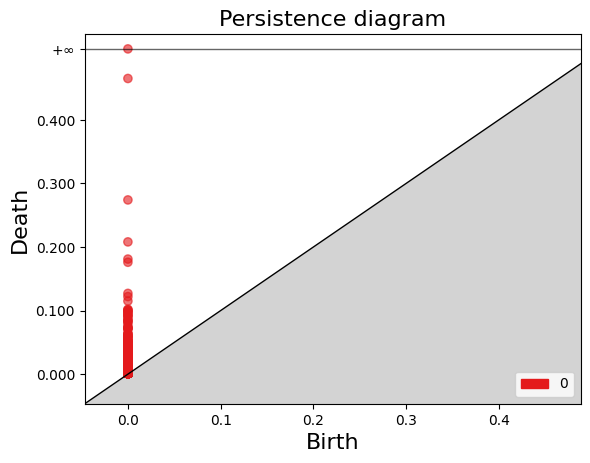

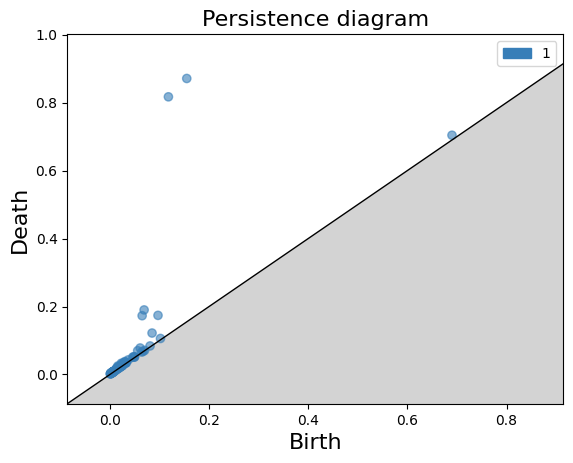

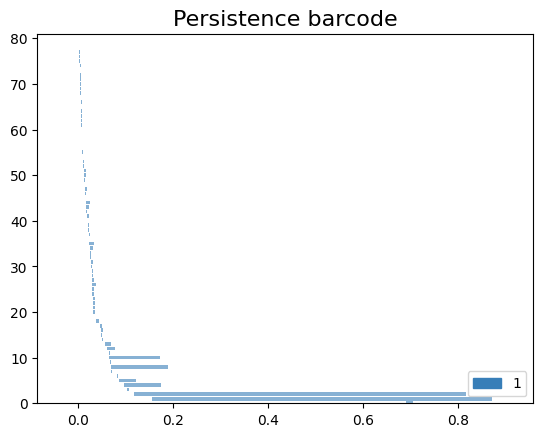

In [107]:
# Get PD and filter function value at query points
import os 
dm_final = -1


if choice_ == 'dtm':

    m = 10/X.shape[0]
    diag,diag_0,diag_1 = get_pd_dtm(X,m,dm_ori)
    plot_PD(diag,diag_0,diag_1,para='dtm_test') 
    print('PD saved (DTM)')


elif choice_ == 'rips':
    dm_final= dm_ori
    rips = Rips()
    dgms = rips.fit_transform(dm_final, distance_matrix=True)
    diag,diag_0,diag_1 = gd_format(dgms)
    plot_PD(diag,diag_0,diag_1,para='rips_test')
    print('PD saved (rips)')



elif choice_ == 'cknn':
    m = 10/X.shape[0] # CkNN
    dm_final = compute_cknn_distance(X,m,dm=dm_ori) #CkNN
    rips = Rips()
    dgms = rips.fit_transform(dm_final, distance_matrix=True)
    diag,diag_0,diag_1 = gd_format(dgms)
    plot_PD(diag,diag_0,diag_1,para='cknn_test')
    print('PD saved (cknn)')


elif choice_ == 'lambda':
    psi = 8
    dm_final = compute_lambda_distance(dm_ori,eta=-1,psi=psi,t=1000) #Lambda
    rips = Rips()
    dgms = rips.fit_transform(dm_final, distance_matrix=True)
    diag,diag_0,diag_1 = gd_format(dgms)
    plot_PD(diag,diag_0,diag_1,para='lambda_test')

